In [1]:
import json
 
f = open('mainnet-graph.json') 
data = json.load(f)
f.close()

print("# nodes = " + str(len(data['nodes'])))
print("# edges = " + str(len(data['edges'])))
 
PK = [x['pub_key'] for x in data['nodes']]
PKtoV = {}
for i in range(len(PK)):
    PKtoV[PK[i]] = i;
    
n = len(data['nodes'])
E = {};
E_w = {};
for v in range(n):
    E[v] = [];
    E_w[v] = [];
for e in data['edges']:
    u = PKtoV[e['node1_pub']]
    v = PKtoV[e['node2_pub']]
    C = int(e['capacity'])
    E[u].append([v, 1]) # unweighted graph
    E[v].append([u, 1])
    E_w[u].append([v, C]) # weighted graph
    E_w[v].append([u, C])


# nodes = 20226
# edges = 86670


In [2]:
# greedy algorithm #1
# returns list partition, s.t. partition[v] = 0/1 depending on the side of v in the partition
def COMPUTE_IMBALANCED_MAX_CUT(n, E, k):
    if (n<k):
        return [];
    partition = [0] * n # initially all nodes are on the 0 side
    for i in range(k):
        print("greedy step " + str(i+1) + "/" + str(k))
        best_vertex = -1;
        best_increase = 0;
        for j in range(n):
            if (partition[j] == 0): # consider only nodes still on the 0 side
                C_cut = 0; # compute total capacity incident to node j in the cut
                C_notcut = 0; # compute total capacity incident to node j NOT in the cut
                for e in E[j]:
                    if (partition[e[0]] == 0):
                        C_notcut += e[1];
                    else:
                        C_cut += e[1];
                new_increase = C_notcut - C_cut;
                if ((best_vertex < 0) or (new_increase > best_increase)):
                    best_vertex = j;
                    best_increase = new_increase;
        partition[best_vertex] = 1; # make best greedy move
    return partition

# returns the capacities of all greedy max cuts for all values of k
# i.e. cut_capacity[i] is the capacity of the greedy max cut with i nodes on one side
# note that cut_capacity[i] for all i>n/2 is ommitted since capacity[i] <= capacity[n-i] in this case
def COMPUTE_ALL_GREEDY_IMBALANCED_MAX_CUTS(n, E):
    cut_capacity = [0]
    edges_count = [0]
    partition = [0] * n # initially all nodes are on the 0 side
    for i in range(int(n/2)): # consider only cuts of up to n/2 nodes on one side
        if (int(i*100/(n/2))>int((i-1)*100/(n/2))):
            print("greedy step " + str(i+1) + "/" + str(n/2))
        best_vertex = -1;
        best_increase = 0;
        for j in range(n):
            if (partition[j] == 0): # consider only nodes still on the 0 side
                C_cut = 0; # compute total capacity incident to node j in the cut
                C_notcut = 0; # compute total capacity incident to node j NOT in the cut
                a = 0
                b = 0
                for e in E[j]:
                    if (partition[e[0]] == 0):
                        C_notcut += e[1];
                        b += 1
                    else:
                        C_cut += e[1];
                        a += 1

                new_increase = C_notcut - C_cut;
                if ((best_vertex < 0) or (new_increase > best_increase)):
                    tmp = b - a
                    best_vertex = j;
                    best_increase = new_increase;
        partition[best_vertex] = 1; # make best greedy move
        cut_capacity.append(cut_capacity[-1] + best_increase)
        edges_count.append(edges_count[-1] + tmp)

       #print(f"Edges for k={i+2}: {edges_count[-1]}")

    return cut_capacity, edges_count

In [3]:
P = COMPUTE_IMBALANCED_MAX_CUT(n, E, 10)
C, edges_count = COMPUTE_ALL_GREEDY_IMBALANCED_MAX_CUTS(n, E)
C_w, edges_count_w = COMPUTE_ALL_GREEDY_IMBALANCED_MAX_CUTS(n, E_w)

greedy step 1/10
greedy step 2/10
greedy step 3/10
greedy step 4/10
greedy step 5/10
greedy step 6/10
greedy step 7/10
greedy step 8/10
greedy step 9/10
greedy step 10/10
greedy step 103/10113.0
greedy step 204/10113.0
greedy step 305/10113.0
greedy step 406/10113.0
greedy step 507/10113.0
greedy step 608/10113.0
greedy step 709/10113.0
greedy step 811/10113.0
greedy step 912/10113.0
greedy step 1013/10113.0
greedy step 1114/10113.0
greedy step 1215/10113.0
greedy step 1316/10113.0
greedy step 1417/10113.0
greedy step 1518/10113.0
greedy step 1620/10113.0
greedy step 1721/10113.0
greedy step 1822/10113.0
greedy step 1923/10113.0
greedy step 2024/10113.0
greedy step 2125/10113.0
greedy step 2226/10113.0
greedy step 2327/10113.0
greedy step 2429/10113.0
greedy step 2530/10113.0
greedy step 2631/10113.0
greedy step 2732/10113.0
greedy step 2833/10113.0
greedy step 2934/10113.0
greedy step 3035/10113.0
greedy step 3137/10113.0
greedy step 3238/10113.0
greedy step 3339/10113.0
greedy step 3

max cut capacity = 217775101121
max cut edges = 61065
k = 10
capacity = 95167834853 / 217775101121 = 43.70%
edges = 8650 / 61065 = 14.17%
k = 20
capacity = 123139109892 / 217775101121 = 56.54%
edges = 15228 / 61065 = 24.94%
k = 30
capacity = 140362856717 / 217775101121 = 64.45%
edges = 17574 / 61065 = 28.78%
k = 40
capacity = 152124162568 / 217775101121 = 69.85%
edges = 21637 / 61065 = 35.43%
k = 50
capacity = 161426265775 / 217775101121 = 74.13%
edges = 25557 / 61065 = 41.85%
k = 60
capacity = 168759161613 / 217775101121 = 77.49%
edges = 29064 / 61065 = 47.60%
k = 70
capacity = 174399944656 / 217775101121 = 80.08%
edges = 31601 / 61065 = 51.75%
k = 80
capacity = 178440330913 / 217775101121 = 81.94%
edges = 33681 / 61065 = 55.16%
k = 90
capacity = 181760730770 / 217775101121 = 83.46%
edges = 34299 / 61065 = 56.17%
k = 100
capacity = 184660981034 / 217775101121 = 84.79%
edges = 35511 / 61065 = 58.15%
k = 110
capacity = 187148885216 / 217775101121 = 85.94%
edges = 36314 / 61065 = 59.47%


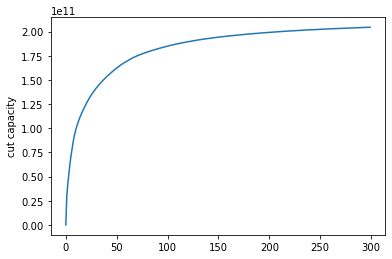

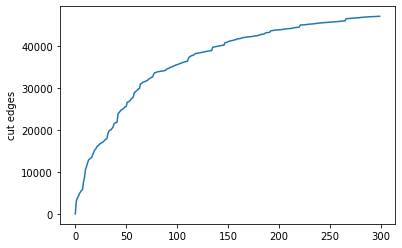

In [5]:
import matplotlib.pyplot as plt

print("max cut capacity = " + str(max(C_w)))
print("max cut edges = " + str(max(edges_count_w)))

for k in range(10, 301, 10):
    print("k = " + str(k))
    print(f'capacity = {C_w[k-1]:d} / {max(C_w):d} = {100*C_w[k-1]/max(C_w):2.2f}%')
    #print(f'edges = {C[k-1]:d} / {max(C):d} = {100*C[k-1]/max(C):2.2f}%')
    print(f'edges = {edges_count_w[k-1]:d} / {max(edges_count_w):d} = {100*edges_count_w[k-1]/max(edges_count_w):2.2f}%')

plt.plot(C_w[0:k])
plt.ylabel('cut capacity')
plt.show()

plt.plot(edges_count_w[0:k])
plt.ylabel('cut edges')
plt.show()

